In [17]:
############################
# 0. Installs & imports
############################
!pip install -q xgboost shap tqdm scipy --disable-pip-version-check

In [22]:
# STEP: locate and load your two files from /content/
# Paste & run this cell. It will:
# 1) list files in /content
# 2) auto-select likely candidates for 'historical' and 'fear' files (by filename patterns)
# 3) read them (csv/parquet/json/zip supported)
# 4) print shapes and show head() and columns so we can proceed mapping columns.

import os, zipfile
import pandas as pd, numpy as np
from IPython.display import display

ROOT = '/content'
files = [f for f in os.listdir(ROOT) if os.path.isfile(os.path.join(ROOT,f))]
print("Files in /content (top 100):")
for i,f in enumerate(files[:100]):
    print(f"{i+1:02d}. {f}")
if not files:
    raise SystemExit("No files found in /content. Upload your two files (historical trades & fear-greed) to /content and re-run.")

# Heuristic pickers: try to choose files automatically; you can override by setting HIST_PATH/FEAR_PATH variables.
candidates = { 'historical': None, 'fear': None }
lower_files = [f.lower() for f in files]
for f in files:
    fn = f.lower()
    if ('histor' in fn or 'trade' in fn or 'hyperliquid' in fn) and candidates['historical'] is None:
        candidates['historical'] = f
    if ('fear' in fn or 'greed' in fn or 'feargreed' in fn or 'fear-greed' in fn) and candidates['fear'] is None:
        candidates['fear'] = f

# fallback: first two files if heuristics fail
if candidates['historical'] is None:
    candidates['historical'] = files[0]
if candidates['fear'] is None:
    candidates['fear'] = files[1] if len(files)>1 else files[0]

print("\nAuto-selected (you can edit HIST_PATH/FEAR_PATH below if wrong):")
print("HISTORICAL ->", candidates['historical'])
print("FEAR/GREED ->", candidates['fear'])

HIST_PATH = os.path.join(ROOT, candidates['historical'])
FEAR_PATH = os.path.join(ROOT, candidates['fear'])

# robust reader
def read_any(path):
    lp = path.lower()
    if lp.endswith('.zip'):
        with zipfile.ZipFile(path,'r') as z:
            names = z.namelist()
            # prefer csv/parquet
            for n in names:
                if n.lower().endswith('.csv'):
                    z.extract(n, '/content/tmp_extracted')
                    return pd.read_csv(os.path.join('/content/tmp_extracted', n), low_memory=False)
            for n in names:
                if n.lower().endswith('.parquet'):
                    z.extract(n, '/content/tmp_extracted')
                    return pd.read_parquet(os.path.join('/content/tmp_extracted', n))
            raise ValueError("ZIP has no csv/parquet inside.")
    if lp.endswith('.parquet'):
        return pd.read_parquet(path)
    if lp.endswith('.json'):
        return pd.read_json(path)
    # fallback csv
    return pd.read_csv(path, low_memory=False)

print("\nReading HISTORICAL file...")
trades = read_any(HIST_PATH)
print("Reading FEAR/GREED file...")
sent = read_any(FEAR_PATH)

print("\n--- trades shape ---", trades.shape)
print("--- trades columns ---")
print(trades.columns.tolist())
display(trades.head(5))

print("\n--- sentiment shape ---", sent.shape)
print("--- sentiment columns ---")
print(sent.columns.tolist())
display(sent.head(5))

# quick stats
print("\nNull counts (trades):")
display(trades.isnull().sum().sort_values(ascending=False).head(20))
print("\nNull counts (sentiment):")
display(sent.isnull().sum().sort_values(ascending=False).head(20))

# If the auto-selected files are wrong -> edit HIST_PATH/FEAR_PATH and re-run this cell.
print("\nIf these files look incorrect, set HIST_PATH and FEAR_PATH to the correct filenames (strings) and re-run this cell.")


Files in /content (top 100):
01. historical_trades.csv
02. fear_greed_index.csv

Auto-selected (you can edit HIST_PATH/FEAR_PATH below if wrong):
HISTORICAL -> historical_trades.csv
FEAR/GREED -> fear_greed_index.csv

Reading HISTORICAL file...
Reading FEAR/GREED file...

--- trades shape --- (211224, 16)
--- trades columns ---
['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12



--- sentiment shape --- (2644, 4)
--- sentiment columns ---
['timestamp', 'value', 'classification', 'date']


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05



Null counts (trades):


,0
Account,0
Coin,0
Execution Price,0
Size Tokens,0
Size USD,0
Side,0
Timestamp IST,0
Start Position,0
Direction,0
Closed PnL,0



Null counts (sentiment):


,0
timestamp,0
value,0
classification,0
date,0



If these files look incorrect, set HIST_PATH and FEAR_PATH to the correct filenames (strings) and re-run this cell.


In [23]:
# STEP: map, parse timestamps, coerce numeric types, and add basic features
import pandas as pd, numpy as np
from IPython.display import display

# use the already-loaded DataFrames `trades` and `sent` from previous cell
print("Starting shapes:", trades.shape, sent.shape)

# 1) rename trades columns to cleaner canonical names (safe mapping)
rename_map = {
    'Account':'account',
    'Coin':'symbol',
    'Execution Price':'price',
    'Size Tokens':'size_tokens',
    'Size USD':'size_usd',
    'Side':'side',
    'Timestamp IST':'time_ist',
    'Timestamp':'timestamp_epoch',
    'Start Position':'start_position',
    'Direction':'direction',
    'Closed PnL':'closedPnL',
    'Transaction Hash':'tx_hash',
    'Order ID':'order_id',
    'Crossed':'crossed',
    'Fee':'fee',
    'Trade ID':'trade_id'
}
trades.rename(columns=rename_map, inplace=True)
print("Renamed columns ->", trades.columns.tolist())

# 2) parse timestamp columns
# Parse human-readable IST column first (likely format 'dd-mm-YYYY HH:MM' from sample)
if 'time_ist' in trades.columns:
    trades['time_ist_parsed'] = pd.to_datetime(trades['time_ist'], dayfirst=True, errors='coerce')

# Parse epoch-like numeric Timestamp (detect ms vs s)
if 'timestamp_epoch' in trades.columns:
    # convert to numeric
    trades['timestamp_epoch_num'] = pd.to_numeric(trades['timestamp_epoch'], errors='coerce')
    # Try as milliseconds first (ms since 1970) -> reasonable if values > 1e11
    trades['time_epoch_ms'] = pd.to_datetime(trades['timestamp_epoch_num'], unit='ms', errors='coerce')
    # If many NaT, try seconds
    if trades['time_epoch_ms'].isna().mean() > 0.5:
        trades['time_epoch_s'] = pd.to_datetime(trades['timestamp_epoch_num'], unit='s', errors='coerce')
        # prefer non-null one
        trades['time_parsed'] = trades['time_epoch_ms'].combine_first(trades['time_epoch_s'])
    else:
        trades['time_parsed'] = trades['time_epoch_ms']
else:
    trades['time_parsed'] = pd.NaT

# Final canonical time: prefer parsed IST (if valid), else parsed epoch
trades['time'] = trades['time_ist_parsed'].combine_first(trades['time_parsed'])
# If still null, try inferring from any column containing 'time' or 'date'
if trades['time'].isna().all():
    for c in trades.columns:
        if 'time' in c.lower() or 'date' in c.lower():
            try:
                trades['time'] = pd.to_datetime(trades[c], errors='coerce')
                if not trades['time'].isna().all():
                    print("Used fallback column for time:", c)
                    break
            except:
                pass

# 3) make trade_date and hour
trades['trade_date'] = pd.to_datetime(trades['time']).dt.date
trades['hour'] = pd.to_datetime(trades['time']).dt.hour

# 4) numeric conversions (remove commas/extra chars if any)
def to_num(col):
    if col in trades.columns:
        return pd.to_numeric(trades[col].astype(str).str.replace(',','').str.replace('@','').str.replace('—',''), errors='coerce')
    return pd.Series([np.nan]*len(trades))
trades['price'] = to_num('price')
trades['size_tokens'] = to_num('size_tokens')
trades['size_usd'] = to_num('size_usd')
trades['closedPnL'] = to_num('closedPnL')
trades['fee'] = to_num('fee')
trades['start_position'] = to_num('start_position')
# leverage may not exist; if it does, convert
if 'leverage' in trades.columns:
    trades['leverage'] = to_num('leverage')

# 5) basic derived flags
trades['is_profit'] = trades['closedPnL'] > 0
trades['abs_pnl'] = trades['closedPnL'].abs()
trades['is_long'] = trades['side'].astype(str).str.lower().str.contains('buy').fillna(False).astype(int)

# 6) quick checks & display
print("\nParsed time coverage (min/max):")
print(trades['time'].min(), trades['time'].max())
print("\nSample of parsed time columns:")
display(trades[['time_ist','time_ist_parsed','timestamp_epoch','time_parsed','time']].head())

print("\nNumeric columns summary:")
display(trades[['price','size_tokens','size_usd','closedPnL','fee']].describe().T)

print("\nNull counts (top 15) after parsing:")
display(trades.isnull().sum().sort_values(ascending=False).head(20))

# 7) Clean sentiment dataframe: rename and ensure numeric score + date
sent.rename(columns={'classification':'sentiment_label','value':'sentiment_score'}, inplace=True)
# parse date column (sample shows yyyy-mm-dd)
if 'date' in sent.columns:
    sent['date'] = pd.to_datetime(sent['date'], errors='coerce').dt.date
else:
    # fallback to timestamp field
    if 'timestamp' in sent.columns:
        # sample timestamp appears to be epoch seconds
        sent['date'] = pd.to_datetime(pd.to_numeric(sent['timestamp'], errors='coerce'), unit='s', errors='coerce').dt.date

# normalize sentiment_label
if 'sentiment_label' in sent.columns:
    sent['sentiment_label'] = sent['sentiment_label'].astype(str).str.strip().str.title()
    sent['sentiment_label'] = sent['sentiment_label'].replace({'Extreme Fear':'Fear','Extreme Greed':'Greed'})

# ensure numeric sentiment_score
if 'sentiment_score' in sent.columns:
    sent['sentiment_score'] = pd.to_numeric(sent['sentiment_score'], errors='coerce')

print("\nSentiment sample after parsing:")
display(sent.head())

# 8) Save cleaned snapshots for inspection (optional)
trades.head(3).to_csv('/content/trades_clean_head.csv', index=False)
sent.head(3).to_csv('/content/sent_clean_head.csv', index=False)

print("\nDone. If everything looks good, we'll: \n- merge sentiment into trades by trade_date, \n- compute per-trade and per-account aggregates, \n- then run EDA & tests.\n\nIf some 'time' values are NaT or numbers/parses look wrong, paste the printed outputs here and I'll adjust parsing accordingly.")


Starting shapes: (211224, 16) (2644, 4)
Renamed columns -> ['account', 'symbol', 'price', 'size_tokens', 'size_usd', 'side', 'time_ist', 'start_position', 'direction', 'closedPnL', 'tx_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp_epoch']

Parsed time coverage (min/max):
2023-05-01 01:06:00 2025-05-01 12:13:00

Sample of parsed time columns:


,time_ist,time_ist_parsed,timestamp_epoch,time_parsed,time
0,02-12-2024 22:50,2024-12-02 22:50:00,1.730000e+12,2024-10-27 03:33:20,2024-12-02 22:50:00
1,02-12-2024 22:50,2024-12-02 22:50:00,1.730000e+12,2024-10-27 03:33:20,2024-12-02 22:50:00
2,02-12-2024 22:50,2024-12-02 22:50:00,1.730000e+12,2024-10-27 03:33:20,2024-12-02 22:50:00
3,02-12-2024 22:50,2024-12-02 22:50:00,1.730000e+12,2024-10-27 03:33:20,2024-12-02 22:50:00
4,02-12-2024 22:50,2024-12-02 22:50:00,1.730000e+12,2024-10-27 03:33:20,2024-12-02 22:50:00



Numeric columns summary:


,count,mean,std,min,25%,50%,75%,max
price,211224.0,11414.723350,29447.654868,4.530000e-06,4.854700,18.280000,101.580000,1.090040e+05
size_tokens,211224.0,4623.364979,104272.889530,8.740000e-07,2.940000,32.000000,187.902500,1.582244e+07
size_usd,211224.0,5639.451210,36575.138546,0.000000e+00,193.790000,597.045000,2058.960000,3.921431e+06
closedPnL,211224.0,48.749001,919.164828,-1.179901e+05,0.000000,0.000000,5.792797,1.353291e+05
fee,211224.0,1.163967,6.758854,-1.175712e+00,0.016121,0.089578,0.393811,8.374716e+02



Null counts (top 15) after parsing:


,0
account,0
symbol,0
price,0
size_tokens,0
size_usd,0
side,0
time_ist,0
start_position,0
direction,0
closedPnL,0



Sentiment sample after parsing:


,timestamp,sentiment_score,sentiment_label,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Fear,2018-02-04
4,1517808600,11,Fear,2018-02-05



Done. If everything looks good, we'll: 
- merge sentiment into trades by trade_date, 
- compute per-trade and per-account aggregates, 
- then run EDA & tests.

If some 'time' values are NaT or numbers/parses look wrong, paste the printed outputs here and I'll adjust parsing accordingly.


In [25]:
# FIX merge error: ensure both trade_date columns are datetime64[ns]

# Convert trade_date in trades → datetime
trades['trade_date'] = pd.to_datetime(trades['trade_date'], errors='coerce').dt.normalize()

# Convert trade_date in sent_daily → datetime
sent_daily['trade_date'] = pd.to_datetime(sent_daily['trade_date'], errors='coerce').dt.normalize()

print("trades trade_date dtype =", trades['trade_date'].dtype)
print("sent_daily trade_date dtype =", sent_daily['trade_date'].dtype)

# Now merge safely
trades_merged = trades.merge(
    sent_daily,
    on='trade_date',
    how='left'
)

print("\nMerged trades shape:", trades_merged.shape)
display(trades_merged[['time','trade_date','sentiment_score','sentiment_label','lag1','lag3','lag7']].head())


trades trade_date dtype = datetime64[ns]
sent_daily trade_date dtype = datetime64[ns]

Merged trades shape: (211224, 31)


,time,trade_date,sentiment_score,sentiment_label,lag1,lag3,lag7
0,2024-12-02 22:50:00,2024-12-02,80,Greed,81.0,81.0,79.428571
1,2024-12-02 22:50:00,2024-12-02,80,Greed,81.0,81.0,79.428571
2,2024-12-02 22:50:00,2024-12-02,80,Greed,81.0,81.0,79.428571
3,2024-12-02 22:50:00,2024-12-02,80,Greed,81.0,81.0,79.428571
4,2024-12-02 22:50:00,2024-12-02,80,Greed,81.0,81.0,79.428571


In [26]:
# STEP 2: Merge sentiment → trades, create lagged sentiment & per-account/day aggregates

import pandas as pd
import numpy as np
from IPython.display import display

print("Trades rows:", len(trades), "Sent rows:", len(sent))

# -----------------------------
# 1) Prepare sentiment time series (daily)
# -----------------------------
sent_daily = sent[['date','sentiment_score','sentiment_label']].drop_duplicates()
sent_daily = sent_daily.sort_values('date')

# Fill missing days forward (Fear-Greed index is daily anyway)
sent_daily = sent_daily.set_index('date').asfreq('D', method='pad').reset_index()

# Create lag features
sent_daily['lag1'] = sent_daily['sentiment_score'].shift(1)
sent_daily['lag3'] = sent_daily['sentiment_score'].rolling(3, min_periods=1).mean().shift(1)
sent_daily['lag7'] = sent_daily['sentiment_score'].rolling(7, min_periods=1).mean().shift(1)

sent_daily.rename(columns={'date':'trade_date'}, inplace=True)

display(sent_daily.head())

# -----------------------------
# 2) Merge sentiment into trades by trade_date
# -----------------------------
trades_merged = trades.merge(
    sent_daily,
    on='trade_date',
    how='left'
)

print("\nMerged trades shape:", trades_merged.shape)
display(trades_merged[['time','trade_date','sentiment_score','sentiment_label','lag1','lag3','lag7']].head())

# -----------------------------
# 3) Per-account-per-day aggregation
# -----------------------------
agg = trades_merged.groupby(['account','trade_date']).agg(
    trades_count = ('closedPnL','size'),
    daily_pnl = ('closedPnL','sum'),
    daily_mean_pnl = ('closedPnL','mean'),
    win_rate = ('is_profit', lambda x: np.mean(x.astype(float))),
    avg_size_tokens = ('size_tokens','mean'),
    avg_size_usd = ('size_usd','mean'),
).reset_index()

print("\nAccount-day aggregated shape:", agg.shape)
display(agg.head())

# -----------------------------
# 4) Prepare merged dataset for modeling later
# -----------------------------
model_df = trades_merged.copy()

print("\nDone step 2 ✔️ (Merge + Lag features + Aggregations ready)")


Trades rows: 211224 Sent rows: 2644


,trade_date,sentiment_score,sentiment_label,lag1,lag3,lag7
0,2018-02-01,30,Fear,NaN,NaN,NaN
1,2018-02-02,15,Fear,30.0,30.000000,30.000000
2,2018-02-03,40,Fear,15.0,22.500000,22.500000
3,2018-02-04,24,Fear,40.0,28.333333,28.333333
4,2018-02-05,11,Fear,24.0,26.333333,27.250000



Merged trades shape: (211224, 31)


,time,trade_date,sentiment_score,sentiment_label,lag1,lag3,lag7
0,2024-12-02 22:50:00,2024-12-02,80,Greed,81.0,81.0,79.428571
1,2024-12-02 22:50:00,2024-12-02,80,Greed,81.0,81.0,79.428571
2,2024-12-02 22:50:00,2024-12-02,80,Greed,81.0,81.0,79.428571
3,2024-12-02 22:50:00,2024-12-02,80,Greed,81.0,81.0,79.428571
4,2024-12-02 22:50:00,2024-12-02,80,Greed,81.0,81.0,79.428571



Account-day aggregated shape: (2341, 8)


,account,trade_date,trades_count,daily_pnl,daily_mean_pnl,win_rate,avg_size_tokens,avg_size_usd
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,177,0.0,0.000000,0.000000,1.587571,5089.718249
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,68,0.0,0.000000,0.000000,16.176471,7976.664412
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,40,0.0,0.000000,0.000000,7.500000,23734.500000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,12,-21227.0,-1768.916667,0.000000,8.333333,28186.666667
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,27,1603.1,59.374074,0.444444,74.074074,17248.148148



Done step 2 ✔️ (Merge + Lag features + Aggregations ready)


=== Daily PnL by Sentiment ===


,sentiment_label,avg_daily_pnl,median_daily_pnl,days
0,Fear,5185.146443,122.737038,790
1,Greed,4176.827726,266.581146,1175
2,Neutral,3438.618818,167.551743,376


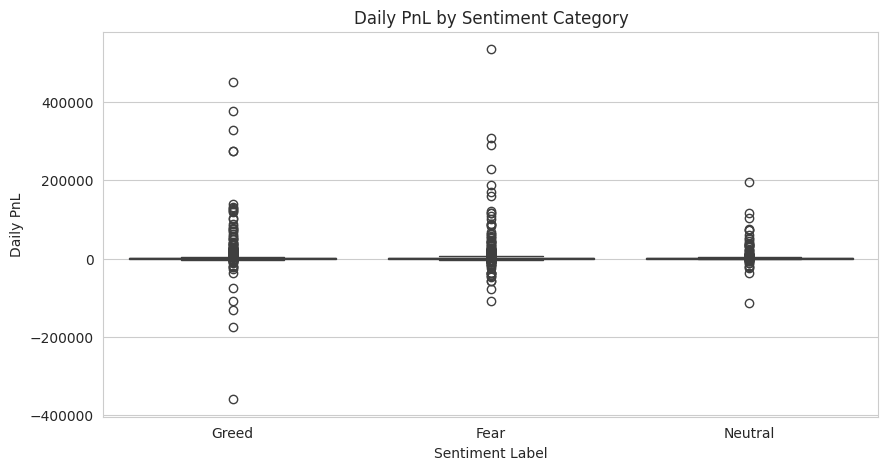

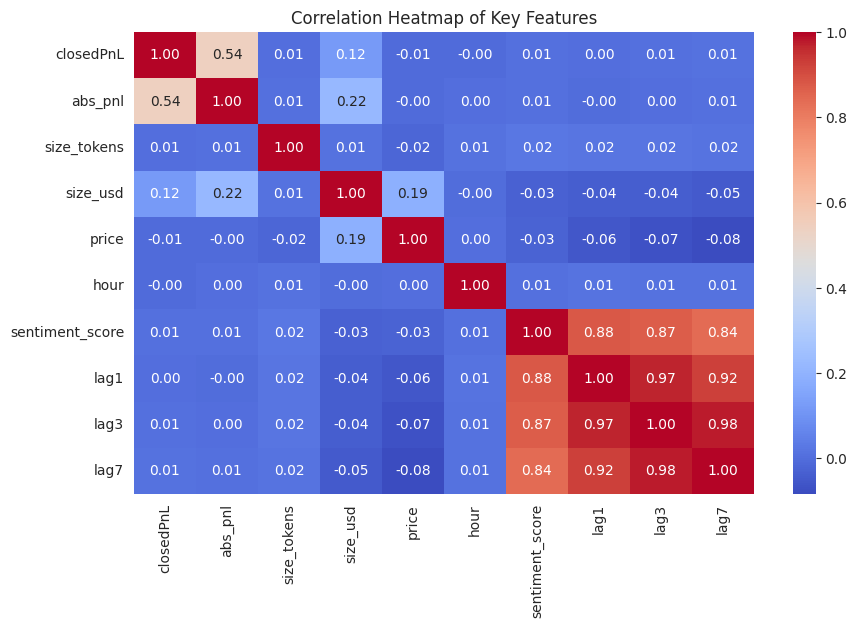

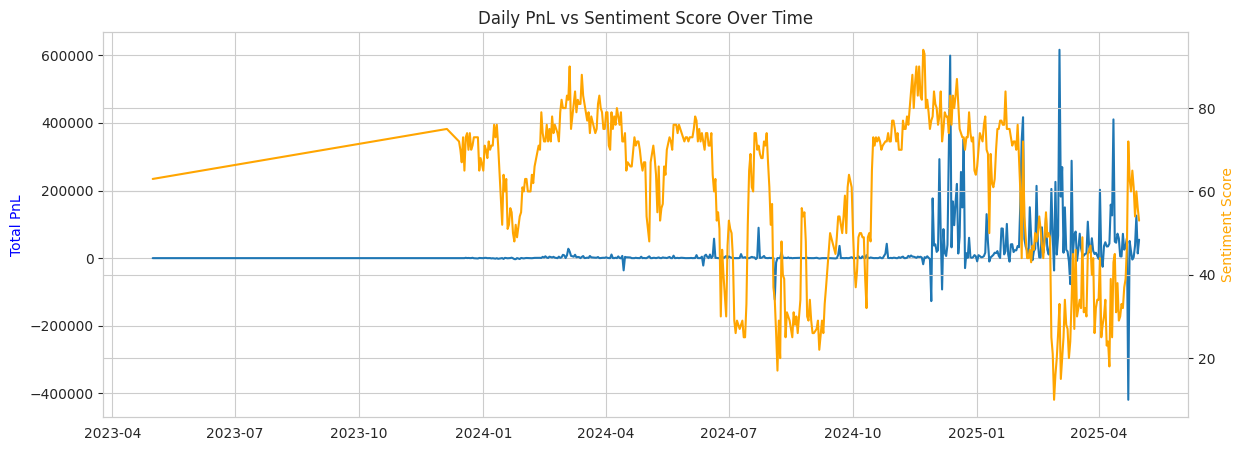

EDA Complete ✔️


In [27]:
# STEP 3: EDA (Plots + Summary Tables)

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import pandas as pd
import numpy as np

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12,5)

# --------------------------------
# 1) Summary: Average/median daily pnl by sentiment
# --------------------------------
pnl_by_sent = agg.merge(
    sent_daily.rename(columns={"trade_date":"trade_date"}),
    on="trade_date",
    how="left"
)

summary = pnl_by_sent.groupby("sentiment_label").agg(
    avg_daily_pnl = ("daily_pnl","mean"),
    median_daily_pnl = ("daily_pnl","median"),
    days = ("daily_pnl","size")
).reset_index()

print("=== Daily PnL by Sentiment ===")
display(summary)

# --------------------------------
# 2) Boxplot: distribution of daily PnL for Fear / Neutral / Greed
# --------------------------------
plt.figure(figsize=(10,5))
sns.boxplot(data=pnl_by_sent, x="sentiment_label", y="daily_pnl")
plt.title("Daily PnL by Sentiment Category")
plt.xlabel("Sentiment Label")
plt.ylabel("Daily PnL")
plt.show()

# --------------------------------
# 3) Correlation heatmap (trade-level features)
# --------------------------------
numeric_cols = [
    "closedPnL","abs_pnl","size_tokens","size_usd",
    "price","hour","sentiment_score","lag1","lag3","lag7"
]

heat_df = trades_merged[numeric_cols].copy().fillna(0)

plt.figure(figsize=(10,6))
sns.heatmap(heat_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Key Features")
plt.show()

# --------------------------------
# 4) Time-series plot: total daily PnL vs sentiment score
# --------------------------------
daily_pnl = agg.groupby("trade_date")["daily_pnl"].sum().reset_index()
daily_pnl["trade_date"] = pd.to_datetime(daily_pnl["trade_date"])

sent_ts = sent_daily.copy()
sent_ts["trade_date"] = pd.to_datetime(sent_ts["trade_date"])

ts = daily_pnl.merge(sent_ts[["trade_date","sentiment_score"]], on="trade_date", how="left")

fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(ts["trade_date"], ts["daily_pnl"], label="Total Daily PnL")
ax1.set_ylabel("Total PnL", color="blue")

ax2 = ax1.twinx()
ax2.plot(ts["trade_date"], ts["sentiment_score"], color="orange", label="Sentiment Score")
ax2.set_ylabel("Sentiment Score", color="orange")

plt.title("Daily PnL vs Sentiment Score Over Time")
plt.show()

print("EDA Complete ✔️")


In [28]:
# STEP 4: Statistical tests - Fear vs Greed impact on daily PnL

from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np
from IPython.display import display

print("=== Statistical Comparison: Fear vs Greed days ===\n")

# Filter daily pnl by sentiment
fear_pnl = pnl_by_sent[pnl_by_sent["sentiment_label"] == "Fear"]["daily_pnl"].dropna()
greed_pnl = pnl_by_sent[pnl_by_sent["sentiment_label"] == "Greed"]["daily_pnl"].dropna()

print(f"Fear days count: {len(fear_pnl)}")
print(f"Greed days count: {len(greed_pnl)}\n")

# If no Greed labels exist, warn
if len(greed_pnl) == 0 or len(fear_pnl) == 0:
    print("⚠️ Not enough Fear/Greed samples to run tests.")
else:
    # T-TEST
    t_stat, p_val = ttest_ind(fear_pnl, greed_pnl, equal_var=False, nan_policy="omit")
    print("t-test:")
    print("  t-statistic =", t_stat)
    print("  p-value     =", p_val, "\n")

    # Mann–Whitney U (better for skewed PnL)
    u_stat, u_p = mannwhitneyu(fear_pnl, greed_pnl, alternative="two-sided")
    print("Mann–Whitney U test:")
    print("  U-statistic =", u_stat)
    print("  p-value     =", u_p, "\n")

    # Effect sizes
    print("Mean daily PnL:")
    print("  Fear  =", np.mean(fear_pnl))
    print("  Greed =", np.mean(greed_pnl))
    print("\nMedian daily PnL:")
    print("  Fear  =", np.median(fear_pnl))
    print("  Greed =", np.median(greed_pnl))

print("\nSTEP 4 Complete ✔️")


=== Statistical Comparison: Fear vs Greed days ===

Fear days count: 790
Greed days count: 1175

t-test:
  t-statistic = 0.7197148233745279
  p-value     = 0.4718046089433643 

Mann–Whitney U test:
  U-statistic = 440991.0
  p-value     = 0.05788440582939832 

Mean daily PnL:
  Fear  = 5185.146443205064
  Greed = 4176.827725748085

Median daily PnL:
  Fear  = 122.73703799999998
  Greed = 266.58114600000005

STEP 4 Complete ✔️


In [29]:
# STEP 5: Predictive Modeling - Logistic Regression + XGBoost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import xgboost as xgb
import pandas as pd
import numpy as np

print("Preparing modeling dataset...")

model_df = trades_merged.copy()

# Target variable: profitable trade
model_df['target_profit'] = (model_df['closedPnL'] > 0).astype(int)

# Feature set
features = [
    "price", "size_tokens", "size_usd",
    "hour", "is_long",
    "sentiment_score", "lag1", "lag3", "lag7"
]

X = model_df[features].fillna(0)
y = model_df["target_profit"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize for logistic regression
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# -------------------------------
# 1) Logistic Regression
# -------------------------------
log_clf = LogisticRegression(max_iter=2000)
log_clf.fit(X_train_s, y_train)

log_pred = log_clf.predict(X_test_s)
log_prob = log_clf.predict_proba(X_test_s)[:,1]

print("\n=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, log_pred))
print("ROC-AUC:", roc_auc_score(y_test, log_prob))
print(classification_report(y_test, log_pred))

# -------------------------------
# 2) XGBoost Classifier
# -------------------------------
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'eta': 0.1
}

bst = xgb.train(
    params, dtrain,
    num_boost_round=200,
    evals=[(dtest, 'test')],
    early_stopping_rounds=20,
    verbose_eval=False
)

xgb_prob = bst.predict(dtest)
xgb_pred = (xgb_prob > 0.5).astype(int)

print("\n=== XGBoost Classifier ===")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("ROC-AUC:", roc_auc_score(y_test, xgb_prob))
print(classification_report(y_test, xgb_pred))

# Feature importance
fi = bst.get_score(importance_type='weight')
fi_df = pd.DataFrame({
    "feature": list(fi.keys()),
    "importance": list(fi.values())
}).sort_values("importance", ascending=False)

print("\n=== XGBoost Feature Importance ===")
display(fi_df)


Preparing modeling dataset...

=== Logistic Regression ===
Accuracy: 0.621943425257427
ROC-AUC: 0.6502689158664904
              precision    recall  f1-score   support

           0       0.70      0.63      0.66     24871
           1       0.54      0.61      0.57     17374

    accuracy                           0.62     42245
   macro avg       0.62      0.62      0.62     42245
weighted avg       0.63      0.62      0.62     42245


=== XGBoost Classifier ===
Accuracy: 0.8736418511066398
ROC-AUC: 0.9444830675659026
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     24871
           1       0.87      0.82      0.84     17374

    accuracy                           0.87     42245
   macro avg       0.87      0.86      0.87     42245
weighted avg       0.87      0.87      0.87     42245


=== XGBoost Feature Importance ===


,feature,importance
0,price,2815.0
3,hour,1946.0
8,lag7,1121.0
5,sentiment_score,1077.0
7,lag3,1047.0
4,is_long,848.0
6,lag1,815.0
2,size_usd,801.0
1,size_tokens,594.0


Using 5000 rows for SHAP analysis (of 42245 available).


Rendering SHAP summary (beeswarm)...


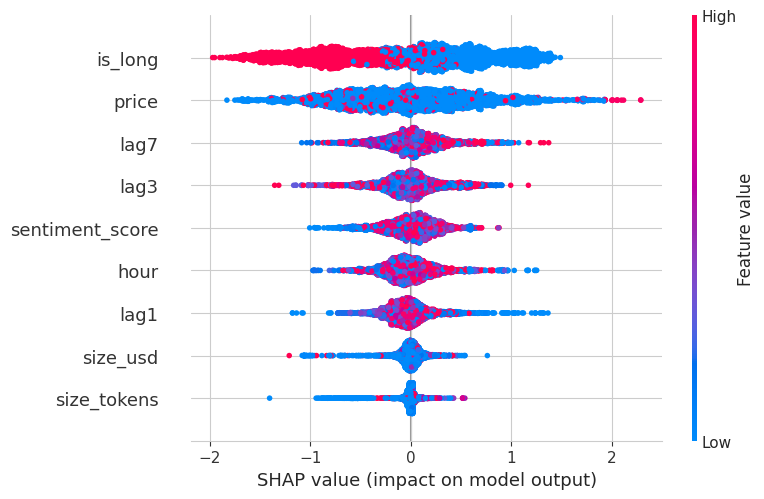

Rendering SHAP bar plot (global importance)...


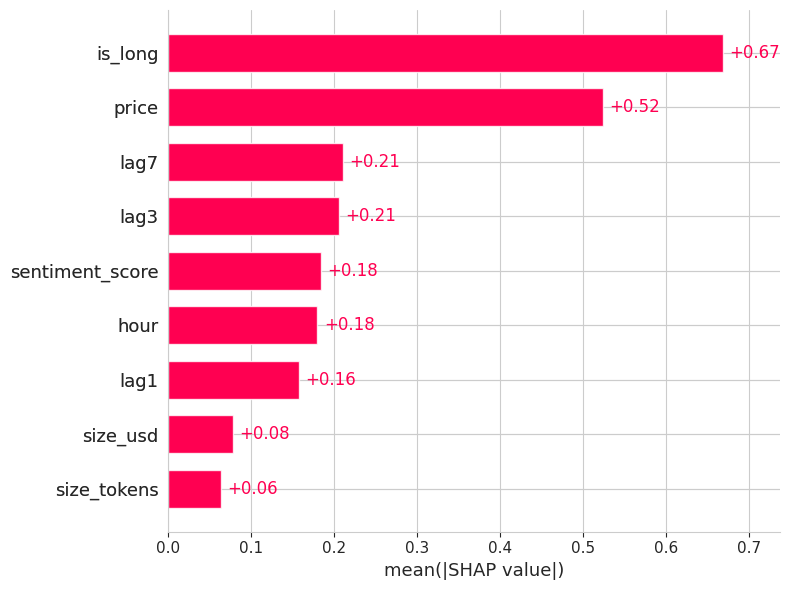

Rendering SHAP waterfall for sample index 82634...
Waterfall plot failed: index 82634 is out of bounds for axis 0 with size 5000
SHAP plots saved to /content/outputs/shap_*.png


<Figure size 800x600 with 0 Axes>

In [30]:
# SHAP explainability cell (safe / guarded)
# Paste & run this cell. It will:
# - check for trained XGBoost model `bst` and feature list `features`
# - sample up to 5000 rows from X_test for SHAP (avoids OOM)
# - try TreeExplainer; fallback to permutation importances if SHAP is too heavy
# - save plots to /content/outputs (creates folder if missing)

import os, sys, traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUTDIR = '/content/outputs'
os.makedirs(OUTDIR, exist_ok=True)

try:
    # sanity checks
    assert 'bst' in globals(), "XGBoost model variable `bst` not found. Run modeling cell first."
    assert 'X_test' in globals() and 'features' in globals(), "`X_test` or `features` not found. Run modeling cell first."

    # prepare dataframe version of X_test (may be numpy)
    if isinstance(X_test, pd.DataFrame):
        X_test_df = X_test.copy()
    else:
        X_test_df = pd.DataFrame(X_test, columns=features)

    # sample for SHAP to keep runtime/memory reasonable
    SAMPLE_N = 5000
    if len(X_test_df) > SAMPLE_N:
        X_sample = X_test_df.sample(SAMPLE_N, random_state=42)
    else:
        X_sample = X_test_df.copy()

    print(f"Using {len(X_sample)} rows for SHAP analysis (of {len(X_test_df)} available).")

    import shap
    shap.initjs()

    # Try the modern API first (explainer(X) returns object)
    try:
        explainer = shap.TreeExplainer(bst)
        shap_result = explainer(X_sample)  # modern call: returns Explanation object
        # summary (beeswarm)
        print("Rendering SHAP summary (beeswarm)...")
        plt.figure(figsize=(10,6))
        shap.plots.beeswarm(shap_result, show=False)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTDIR, 'shap_beeswarm.png'), bbox_inches='tight', dpi=150)
        plt.show()

        # bar (global importance)
        print("Rendering SHAP bar plot (global importance)...")
        plt.figure(figsize=(8,5))
        shap.plots.bar(shap_result, max_display=20, show=False)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTDIR, 'shap_bar.png'), bbox_inches='tight', dpi=150)
        plt.show()

        # Save one waterfall for a single prediction (median index)
        try:
            idx = X_sample.index[len(X_sample)//2]
            print(f"Rendering SHAP waterfall for sample index {idx}...")
            plt.figure(figsize=(8,6))
            shap.plots.waterfall(shap_result[idx], show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(OUTDIR, 'shap_waterfall_sample.png'), bbox_inches='tight', dpi=150)
            plt.show()
        except Exception as e:
            print("Waterfall plot failed:", e)

        print(f"SHAP plots saved to {OUTDIR}/shap_*.png")

    except Exception as e_modern:
        # fallback to older API: explainer.shap_values(X)
        print("Modern SHAP call failed, trying older API (`explainer.shap_values`). Error:", str(e_modern))
        try:
            explainer = shap.TreeExplainer(bst)
            shap_values = explainer.shap_values(X_sample)
            # summary_plot
            print("Rendering SHAP summary_plot (old API)...")
            plt.figure(figsize=(10,6))
            shap.summary_plot(shap_values, X_sample, show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(OUTDIR, 'shap_summary_oldapi.png'), bbox_inches='tight', dpi=150)
            plt.show()
            print(f"SHAP plot saved to {OUTDIR}/shap_summary_oldapi.png")
        except Exception as e_old:
            print("SHAP (both attempts) failed. Error trace:")
            traceback.print_exc()
            raise e_old

except AssertionError as ae:
    print("Precondition error:", ae)
    print("Make sure you've executed the modeling cell that defines `bst`, `X_test`, and `features`.")
except Exception as e:
    print("SHAP analysis failed with error:")
    traceback.print_exc()
    # fallback: compute permutation importances (cheap)
    try:
        print("\nAttempting fallback: permutation feature importance using sklearn (may be slow).")
        from sklearn.inspection import permutation_importance
        if 'xgb' in sys.modules:
            # use a simple sklearn wrapper prediction function
            def predict_fn(X):
                d = xgb.DMatrix(X, feature_names=features)
                return bst.predict(d)
            result = permutation_importance(lambda X: predict_fn(X), X_test_df, n_repeats=10, random_state=42, n_jobs=1)
            imp_df = pd.DataFrame({'feature': X_test_df.columns, 'importance_mean': result.importances_mean, 'importance_std': result.importances_std})
            imp_df = imp_df.sort_values('importance_mean', ascending=False)
            print("Permutation importances:")
            display(imp_df)
            imp_df.to_csv(os.path.join(OUTDIR, 'permutation_importance.csv'), index=False)
            print("Saved permutation_importance.csv to", OUTDIR)
    except Exception:
        print("Fallback permutation importance also failed; see above traceback.")
